<a href="https://colab.research.google.com/github/issmythe/intepretable-ai-crops/blob/main/feature_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#@title Mount drive
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
#@title Installs
! pip install geopandas &> /dev/null
! pip install -U kaleido &> /dev/null


In [ ]:
#@title Imports
import sys
sys.path.append('drive/MyDrive/current_research_projects/utils/')
sys.path.append('drive/MyDrive/current_research_projects/dl_yield_forecasts/code/src/py/')

import copy
import gc
import importlib
import itertools
import math
import os
import pickle
import random
import time
from collections import defaultdict

import numpy as np
import geopandas as gpd
import pandas as pd

# Analysis
from datetime import datetime, timedelta
from scipy.stats import pearsonr

from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

# Plotting
import matplotlib
import plotly
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly import subplots

# Utils
from read_data import get_max_vi, get_modis_vi, get_sif, get_weather, get_yields
from dl_helpers import fit_predict_fold, test
from data_object import (
    DataObj, DataObj2D, DataObjPretrain, BaggingDataObj, DummyDataObj, InterpDataObj)

from networks.network import Network
from networks.basic_cnn import BasicCNN
from networks.basic_lstm import BasicLSTM
from networks.hybrid_lstm import HybridLSTM
from networks.segmented_cnn import SegmentedCNN

# Tensorflow
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard


In [ ]:
#@title Constants
DATA_PATH = 'drive/MyDrive/current_research_projects/us_data/'
DL_DATA_PATH = 'drive/MyDrive/current_research_projects/dl_yield_forecasts/data/'

# HEAT_DATA_PATH = 'drive/MyDrive/research_ideas/heat_separability/data/'
datestr = datetime.today().strftime('%Y%m')
FIG_PATH = f'drive/MyDrive/current_research_projects/dl_yield_forecasts/figs/{datestr}/'
! mkdir -p $FIG_PATH

PROCESS_DATA = False
END_YEAR_INC = 2021


# Data

In [ ]:
#@title Get yields
yields = get_yields(2000, END_YEAR_INC, True).drop('Unnamed: 0', axis=1)

yield_pre_preds = pd.read_csv(f'{DL_DATA_PATH}/preprocessed_data/pretrain_labels.csv')
yield_pre_preds['label_pred'] = yield_pre_preds.apply(
    lambda x: [x[f'pred_{i + 1}'] for i in range(17)], axis=1)
yield_pre_preds['label_delta'] = yield_pre_preds.apply(
    lambda x: [x[f'delta_{i}'] for i in range(17)], axis=1)
yield_pre_preds = yield_pre_preds[['fips', 'year', 'label_pred', 'label_delta']]
yield_pre_preds['fips'] = yield_pre_preds['fips'].apply(lambda x: str(x).zfill(5))


In [ ]:
#@title Read pre-processed features
# See dl_models.ipynb for pre-processing code
daily_data = pd.read_csv(
    DL_DATA_PATH + 'preprocessed_data/prediction_df_through_2021_with_temp.csv')

daily_data['fips'] = daily_data['fips'].apply(lambda x: str(x).zfill(5))

to_list = lambda x: [float(v) for v in x.strip('[').strip(']').split(', ')]
for col in ['evi', 'evi_mini', 'dday10C', 'dday29C', 'prec', 'tMin', 'tMax']:
    daily_data[col] = daily_data[col].apply(to_list)

weather_cols = ['dday29C', 'dday10C', 'prec']
daily_data = daily_data.rename({f'{c}_march_aug': f'{c}_total' for c in weather_cols}, axis=1)\
    .drop([f'{c}_april_sept' for c in weather_cols], axis=1)

daily_data = daily_data.merge(yields).assign(reg_year=daily_data['year'] - daily_data['year'].min())

daily_data = pd.get_dummies(daily_data, columns=['fips', 'state']).assign(
    fips=daily_data['fips'], state=daily_data['state'])


In [ ]:
#@title Filter and format pre-processed features
def clip(df, var, thresh=0.0005):
    return df[(df[var] >= df[var].quantile(thresh)) & (df[var] <= df[var].quantile(1 - thresh))]

feature_df = daily_data.merge(clip(daily_data, 'dday29C_total')[['fips', 'year']])\
    .merge(clip(daily_data, 'dday10C_total')[['fips', 'year']])\
    .merge(clip(daily_data, 'prec_total')[['fips', 'year']])

for col in ['dday10C', 'dday29C', 'prec', 'tMin', 'tMax']:
    feature_df[col] = feature_df[col].apply(lambda x: x[60:-30])
    feature_df[f'{col}_total'] = feature_df[col].apply(sum)

feature_df['idx'] = feature_df['fips'] + '_' + feature_df['year'].astype(str)


In [ ]:
#@title Get EVI pre-train labels
evi_ts_df = pd.read_csv(f'{DL_DATA_PATH}/preprocessed_data/pretrain_evi.csv')
evi_ts_df = evi_ts_df.groupby(['fips', 'year'])['evi_z'].apply(list).reset_index().merge(
    evi_ts_df.groupby(['fips', 'year'])['evi_z_delta'].apply(list).reset_index())
evi_ts_df['fips'] = evi_ts_df['fips'].apply(lambda x: str(x).zfill(5))

feature_df = feature_df.merge(evi_ts_df)#.merge(
    # weather_z[['fips', 'year', 'prec_z', 'tMin_z', 'tMax_z']])


In [ ]:
#@title Constants
ts_cols = ['tMin', 'tMax', 'prec']

state_cols = [x for x in feature_df.columns if x.startswith('state_')]
fips_cols = [x for x in feature_df.columns if x.startswith('fips_')]
year_cols = [
    x for x in feature_df.columns if x.startswith('reg_year_') or x.startswith('reg_year2_')]
flat_cols = ['reg_year'] + fips_cols

random.seed(123)
years = [x for x in range(2000, END_YEAR_INC + 1)]
random.shuffle(years)
FOLDS = np.array_split(years, 10)

np.random.seed(123)
train_years_gs = [x for x in range(2000, 2017)]
np.random.shuffle(train_years_gs)
GS_FOLDS = np.array_split(train_years_gs, 5)


In [ ]:
#@title Eval helpers
def get_rmse(c1, c2):
    return ((c1 - c2) ** 2).mean() ** 0.5

def get_corr(c1, c2):
    return pearsonr(c1, c2)[0]

def get_r2(c1, c2):
    return pearsonr(c1, c2)[0] ** 2

def get_lm_performance(fold, train=False):
    def _get_stats(df):
        if train:
            sample_df = df[~df['year'].isin(FOLDS[fold])]
        else:
            sample_df = df[df['year'].isin(FOLDS[fold])]
        return round(get_rmse(sample_df['pred'], sample_df['log_yield']), 3), \
               round(pearsonr(sample_df['pred'], sample_df['log_yield'])[0], 3)

    print('Baseline RMSE, R:', _get_stats(lm_preds_bl))
    print('March RMSE, R:', _get_stats(lm_preds_march))
    print('April RMSE, R:', _get_stats(lm_preds_april))
    print('USDA season RMSE, R:', _get_stats(lm_preds_season))

def quick_summarize(df, pred_col='pred', label='', verbose=True):
    r = get_corr(df['log_yield'], df[pred_col])
    rmse = get_rmse(df['log_yield'], df[pred_col])
    if verbose:
        print(label, round(r, 3), round(rmse, 3))
    return r, rmse


In [ ]:
#@title Read linear model results
HEAT_DATA_PATH = 'drive/MyDrive/current_research_projects/heat_separability/data/'
yield_lm_dir = f'{HEAT_DATA_PATH}/yield_predictions/'

lm_preds_bl = pd.read_csv(f'{yield_lm_dir}/baseline_preds_31_states.csv')
lm_preds_march = pd.read_csv(f'{yield_lm_dir}/march_through_aug_31_states.csv')
lm_preds_april = pd.read_csv(f'{yield_lm_dir}/april_through_sept_31_states.csv')
lm_preds_season = pd.read_csv(f'{yield_lm_dir}/doy_full_season_31_states.csv')

def quick_summarize(preds):
    rmse = get_rmse(preds['log_yield'], preds['pred'])
    r2 = get_r2(preds['log_yield'], preds['pred'])
    print('N =', len(preds), 'RMSE:', round(rmse, 3), 'R2:', round(r2, 3))

print('Expected N:', len(yields))
quick_summarize(lm_preds_bl)
quick_summarize(lm_preds_april)
quick_summarize(lm_preds_march)
quick_summarize(lm_preds_season)

for df in [lm_preds_bl, lm_preds_april, lm_preds_march, lm_preds_season]:
    train_df = df[df['year'] < 2017]
    print(round(get_rmse(train_df['log_yield'], train_df['pred']), 3),
          round(get_corr(train_df['log_yield'], train_df['pred']), 3))


In [ ]:
#@title Helpers to make in-sample LM preds
fixed_ddays = pd.read_csv(f'{DATA_PATH}/weather/processed/march_through_aug_31_states.csv')
fixed_ddays['fips'] = fixed_ddays['fips'].apply(lambda x: str(x).zfill(5))

def fit_reg(formula, df):
    df = df.merge(yields.drop('state', axis=1))
    reg = smf.ols(formula=formula, data=df).fit()
    # reg.save(f'{ins_dir}/{outdir}.pickle')
    params = pd.DataFrame(reg.params).rename({0: 'beta'}, axis=1)\
        .merge(reg.conf_int(), left_index=True, right_index=True).reset_index()
    preds = df[['fips', 'year', 'log_yield']].assign(lm_pred=reg.predict(df))

    return reg, params, preds


def get_pred_df(ddays):
    df = ddays.assign(reg_year=ddays['year'] - ddays['year'].min(),
                      reg_year2=(ddays['year'] - ddays['year'].min()) ** 2)
    for c in df:
        if c.startswith('prec'):
            df[f'{c}_2'] = df[c] ** 2

    # De-colinearize
    fips_counts = df.groupby('fips')['year'].count().reset_index()
    singles = fips_counts.loc[fips_counts['year'] == 1, 'fips'].to_list()
    df = df.assign(fips_reg=df['fips'].apply(lambda x: x if x not in singles else -1))

    return df


def do_insample_reg(ddays):
    pred_df = get_pred_df(ddays).sample(frac=1)
    baseline_fts = 'reg_year : C(state) + reg_year2 : C(state) + C(fips_reg)'
    formula = 'log_yield ~ ' + ' + '.join([baseline_fts, 'cum10C', 'cum29C', 'cum_prec'])
    return fit_reg(formula, pred_df)



# Optional data

In [ ]:
#@title Prediction helpers
def get_predictions(model, device, data_obj):
    model.eval()
    with torch.no_grad():
        x, x_flat = data_obj.test_x
        data = (torch.Tensor(x).to(device), torch.Tensor(x_flat).to(device))
        target = torch.Tensor(data_obj.test_y).to(device)
        outputs = model(data)
        preds = outputs.detach().cpu().numpy() \
            if (device.type == 'cuda' or device.type == 'mps') \
            else outputs.detach().numpy()

    return data_obj.test_pd[['idx', 'year', 'fips', 'log_yield']].assign(
        pred=data_obj.ss_y.inverse_transform(preds.reshape(data_obj.test_y.shape)).flatten())


In [ ]:
#@title Prediction setup
y_col = 'evi_z'
ts_cols = ['tMin', 'tMax', 'prec']
years = [x for x in range(2000, END_YEAR_INC + 1)]
pretrain_do = DataObj(feature_df, [2000], [2000], years, ts_cols, flat_cols, y=y_col)
full_do = DataObj(feature_df, [2000], [2000], years, ts_cols, flat_cols)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

do = InterpDataObj(feature_df, ts_cols, flat_cols)
do.update_test_data(feature_df)

del daily_data
gc.collect()


In [ ]:
#@title Read in pre-trained models
out_dir = f'{DL_DATA_PATH}/models/pretrain_3_temperature_unnorm/'

pretrain_loc = 3
models, rmses, corrs, orig_preds = [], [], [], []

for i in range(10):
    m = HybridLSTM(use_best_params=True, use_ddays=False, read_params=False,
                   verbose=False, pretrain_loc=pretrain_loc, pretrain=False)
    m.load_state_dict(torch.load(f'{out_dir}/{i}_unnorm.pth'))
    models.append(m)

    model_preds = get_predictions(m, device, do)
    orig_preds.append(model_preds)

    r = get_corr(model_preds['log_yield'], model_preds['pred'])
    rmse = get_rmse(model_preds['log_yield'], model_preds['pred'])
    corrs.append(r)
    rmses.append(rmse)
    print(i, round(r, 3), round(rmse, 3))

import gc
del pretrain_do, full_do
gc.collect()


In [ ]:
#@title Get county shapefile
counties = gpd.read_file(f'{DATA_PATH}/geo/counties_epsg4326.shp')
counties = counties.rename({'GEOID': 'fips'}, axis=1)
counties['state'] = counties['fips'].str[:2]
states = counties.dissolve(by='state').reset_index()
plot_states = counties.loc[counties.centroid.x > -100, 'state'].unique()

tolerance = 0.01
counties_plot = counties.assign(
    geometry=counties['geometry'].simplify(tolerance, preserve_topology=True))
states_plot = states.assign(
    geometry=states['geometry'].simplify(tolerance, preserve_topology=True))
states_plot = states_plot[states_plot['state'].isin(plot_states)]


In [ ]:
#@title Get in-sample LM preds
lm, lm_params, lm_preds = do_insample_reg(fixed_ddays)


# Verify DL model prediction accuracy

In [ ]:
#@title Setup
HEAT_DATA_PATH = 'drive/MyDrive/current_research_projects/heat_separability/data/'
yield_lm_dir = f'{HEAT_DATA_PATH}/yield_predictions/'
lm_preds_march = pd.read_csv(f'{yield_lm_dir}/march_through_aug_31_states.csv')
dl_preds = pd.read_csv(f'{DL_DATA_PATH}/bagging/pretrain_3_temperature2.csv')


In [ ]:
#@title Breakdown of DL vs. LM out-of-sample accuracy
lm_preds_sample = lm_preds_march.merge(dl_preds[['fips', 'year']])
lm_preds_sample['se'] = (lm_preds_sample['log_yield'] - lm_preds_sample['pred']) ** 2

# Compare overall prediction performance
_ = quick_summarize(lm_preds_sample)
_ = quick_summarize(dl_preds)

# Compare performance by year
dl_preds['se'] = (dl_preds['log_yield'] - dl_preds['pred']) ** 2
dl_year = dl_preds.groupby('year')['se'].mean().reset_index().rename({'se': 'dl_err'}, axis=1)
lm_year = lm_preds_sample.groupby('year')['se'].mean().reset_index().rename({'se': 'lm_err'}, axis=1)
compare_year = dl_year.merge(lm_year)
compare_year['dl_err'] **= 0.5
compare_year['lm_err'] **= 0.5

# Compare performance by county
dl_fips = dl_preds.groupby('fips')['se'].mean().reset_index().rename({'se': 'dl_err'}, axis=1)
lm_fips = lm_preds_sample.groupby('fips')['se'].mean().reset_index().rename({'se': 'lm_err'}, axis=1)
compare_fips = dl_fips.merge(lm_fips)
compare_fips['dl_err'] **= 0.5
compare_fips['lm_err'] **= 0.5
compare_fips['fips'] = compare_fips['fips'].apply(lambda x: str(x).zfill(5))

print(compare_year)
compare_fips['delta'] = compare_fips['dl_err'] - compare_fips['lm_err']
compare_fips['delta'].quantile(0.01), compare_fips['delta'].quantile(0.99), \
len(compare_fips), len(compare_fips[compare_fips['dl_err'] < compare_fips['lm_err']])


In [ ]:
#@title Verify DL vs. LM in-sample accuracy
# DL model is more prone to overfitting ->
# making sure it outperforms the LM in-sample is just a sanity check

def agg_se(df, pred_col, agg_col):
    df['se'] = (df['log_yield'] - df[pred_col]) ** 2
    df = df.groupby(agg_col)['se'].mean().reset_index()
    df['se'] **= 0.5
    return df

dl_ins = pd.concat(orig_preds)
dl_ins = dl_ins.groupby(['fips', 'year'])[['log_yield', 'pred']].median().reset_index()
_ = quick_summarize(lm_preds.rename({'lm_pred': 'pred'}, axis=1))
_ = quick_summarize(dl_ins)

compare_year_ins = agg_se(lm_preds, 'lm_pred', 'year').rename({'se': 'lm_err'}, axis=1).merge(
    agg_se(dl_ins, 'pred', 'year').rename({'se': 'dl_err'}, axis=1))
compare_fips_ins = agg_se(lm_preds, 'lm_pred', 'fips').rename({'se': 'lm_err'}, axis=1).merge(
    agg_se(dl_ins, 'pred', 'fips').rename({'se': 'dl_err'}, axis=1))
compare_fips_ins['delta'] = compare_fips_ins['dl_err'] - compare_fips_ins['lm_err']


In [ ]:
#@title Map lm vs. dl mean county error

def plot_err_cmp(err_df):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 8), gridspec_kw={'wspace': 0})

    ax1.set_title('Deep learning error')
    ax2.set_title('Linear model error')
    ax3.set_title('Difference in error')

    counties_plot.merge(err_df).plot(column='dl_err', ax=ax1, cmap='magma_r', vmin=0, vmax=0.5)
    counties_plot.merge(err_df).plot(column='lm_err', ax=ax2, cmap='magma_r', vmin=0, vmax=0.5)
    counties_plot.merge(err_df).plot(column='delta', ax=ax3, vmin=-0.2, vmax=0.2, cmap='RdBu_r')

    for ax in [ax1, ax2, ax3]:
        states_plot.plot(ax=ax, linewidth=1, edgecolor='darkgray', facecolor='none')
        ax.set_axis_off()

    return fig

oos_err_cmp = plot_err_cmp(compare_fips)
oos_err_cmp.show()

ins_err_cmp = plot_err_cmp(compare_fips_ins)
ins_err_cmp.show()


# Permutation importance

In [ ]:
#@title Shared helpers
def permute_fips(df):
    fips_cols = [x for x in feature_df.columns if x.startswith('fips_')]
    df['fips'] = df['fips'].sample(frac=1, random_state=123).to_list()
    df = pd.get_dummies(df.drop(fips_cols, axis=1), columns=['fips']).assign(fips=df['fips'])
    for c in list(set(fips_cols) - set(df.columns)):
        df[c] = 0
    return df


def shuffle_weather(df, i, shuffle_cols=None, seed=123):
    shuffle_cols = shuffle_cols if shuffle_cols else ['tMin', 'tMax', 'prec']

    for c in shuffle_cols:
        np.random.seed(seed) # ensure all columns are shuffled in the same order
        arr = np.stack(df[c])

        before = arr[:, :i * 15]
        shuffle = arr[:, i * 15: (i + 1) * 15]
        after = arr[:, (i + 1) * 15:]

        np.random.shuffle(shuffle)
        new_arr = np.concatenate((before, shuffle, after), axis=1)
        df[c] = new_arr.tolist()

    return df


##**Calculate permutation importance

Only needs to be run once - after that output can just be read in for downstream analysis

In [ ]:
#@title Get importance - DL
results = defaultdict(list)
out_dir = f'{DL_DATA_PATH}/interpretation/'

# Do year and weather cols
for c in ['year', 'tMin', 'tMax', 'prec']:
    do.update_test_data(feature_df.assign(
        **{c: feature_df[c].sample(frac=1, random_state=123).to_list()}))

    for m in models:
        r, rmse = quick_summarize(get_predictions(m, device, do), label=c)
        results[f'{c}_r'].append(r)
        results[f'{c}_rmse'].append(rmse)
        gc.collect()

pd.DataFrame(results).to_csv(f'{out_dir}/importance_unnorm.csv', index=False)

# Do fips (takes a while)
do.update_test_data(permute_fips(feature_df))
for m in models:
    r, rmse = quick_summarize(get_predictions(m, device, do), label='fips')
    results['fips_r'].append(r)
    results['fips_rmse'].append(rmse)
    gc.collect()

pd.DataFrame(results).to_csv(f'{out_dir}/importance_unnorm.csv', index=False)

# Do weather chunks
for i in range(18):
    do.update_test_data(shuffle_weather(feature_df.copy(), i))
    for m in models:
        r, rmse = quick_summarize(get_predictions(m, device, do), label=f'weather {i}')
        results[f'weather{i}_r'].append(r)
        results[f'weather{i}_rmse'].append(rmse)
        gc.collect()

pd.DataFrame(results).to_csv(f'{out_dir}/importance_unnorm.csv', index=False)

# Get weather period importance separated by county
t0 = time.time()
results = []
for i in range(2, 14):
    do.update_test_data(shuffle_weather(feature_df.copy(), i))
    for m in range(len(models)):
        preds = get_predictions(models[m], device, do)
        preds['se'] = (preds['log_yield'] - preds['pred']) ** 2
        fips_rmse = preds.groupby('fips')['se'].mean().reset_index().assign(m=m, period=i)
        fips_rmse['se'] **= 0.5
        results.append(fips_rmse)
        gc.collect()

    print(i, round(time.time() - t0), 'elapsed')
    pd.concat(results).to_csv(f'{out_dir}/weather_importance_by_fips.csv', index=False)



In [ ]:
#@title LM helpers
n_days = (datetime(2023, 9, 1) - datetime(2023, 3, 1)).days

def shuffle_lm_weather(i, seed=123):
    return fixed_ddays.assign(cum10C=fixed_ddays['cum10C'] + get_delta('dday10C', i),
                              cum29C=fixed_ddays['cum29C'] + get_delta('dday29C', i),
                              cum_prec=fixed_ddays['cum_prec'] + get_delta('prec', i))


def get_delta(col, i, seed=123):
    df = daily_data[['fips', 'year'] + col].copy()

    arr = np.stack(df[col])
    shuffle = arr[:, i * 15: (i + 1) * 15]
    orig = shuffle.sum(axis=1)

    np.random.seed(seed)
    np.random.shuffle(shuffle)
    return orig - shuffle.sum(axis=1)


In [ ]:
#@title Get importance - LM
results = defaultdict(list)

for c in ['year', 'cum10C', 'cum29C', 'cum_prec', 'fips']:
    perm_df = fixed_ddays.merge(yields).assign(
        **{c: fixed_ddays[c].sample(frac=1, random_state=123).to_list()})
    perm_df = perm_df.assign(pred=lm.predict(get_pred_df(perm_df)))
    r, rmse = quick_summarize(perm_df, label=c)

    results[f'{c}_r'].append(r)
    results[f'{c}_rmse'].append(rmse)
    break

for i in range(12):
    perm_df = shuffle_lm_weather(i).merge(yields)
    perm_df = perm_df.assign(pred=lm.predict(get_pred_df(perm_df)))
    r, rmse = quick_summarize(perm_df, label=f'weather {i}')
    results[f'weather{i}_r'].append(r)
    results[f'weather{i}_rmse'].append(rmse)

r, rmse = quick_summarize(lm_preds, 'lm_pred')
pd.DataFrame(results).assign(r=r, rmse=rmse).to_csv(
    f'{DL_DATA_PATH}/interpretation/importance_lm.csv', index=False)


##**Visualizations and analysis

In [ ]:
#@title Read importance data
dl_importance = pd.read_csv(f'{DL_DATA_PATH}/interpretation/importance_unnorm.csv')
lm_importance = pd.read_csv(f'{DL_DATA_PATH}/interpretation/importance_lm.csv')


In [ ]:
#@title Check overall performance of DL and LM models
def _get_performance(df, col):
    return round(df[col].mean(), 3), round(df[col].min(), 3), round(df[col].max(), 3)

r_avg, r_l, r_u = _get_performance(dl_importance, 'r')
rmse_avg, rmse_l, rmse_u = _get_performance(dl_importance, 'rmse')
r_lm, _, _ = _get_performance(lm_importance, 'r')
rmse_lm, _, _= _get_performance(lm_importance, 'rmse')

print(r_avg, f'({r_l}, {r_u})', r_lm)
print(rmse_avg, f'({rmse_l}, {rmse_u})', rmse_lm)


In [ ]:
#@title Make summary df
def _process_col(col, df):
    pct = (df[col] - df['rmse']) / df['rmse'] * 100
    return pct.mean(), pct.min(), pct.max()

def _process_df(df, rename_dict=None):
    change = {}
    for col in [x for x in df.columns if x.endswith('_rmse')]:
        change[col.replace('_rmse', '')] = _process_col(col, df)
    change = pd.DataFrame(change)
    if rename_dict:
        change = change.rename(rename_dict, axis=1)

    return change.T.reset_index()

dl_change = _process_df(dl_importance)
dl_change.columns = ['var', 'avg', 'lower', 'upper']

rename_dict = {'cum10C': 'tMin', 'cum29C': 'tMax', 'cum_prec': 'prec'}
lm_change = _process_df(lm_importance, rename_dict).drop([1, 2], axis=1)
lm_change.columns = ['var', 'lm_avg']
change_df = dl_change.merge(lm_change, how='outer')


In [ ]:
#@title Plotting helpers
def add_data(fig, plot_df, line_color, ci, label, col, colname='avg'):
    for i, row in plot_df.dropna(subset=[colname]).iterrows():
        kwargs = dict(mode='markers', line_color=line_color)
        if i == 0 and label is not None and col == 1:
            kwargs['name'] = label
        else:
            kwargs['showlegend'] = False
        if ci:
            kwargs['error_y'] = dict(type='data', symmetric=False,
                array=[row['upper'] - row['avg']], arrayminus=[row['avg'] - row['lower']])
        fig.add_trace(go.Scatter(x=[i], y=[row[colname]], **kwargs), row=1, col=col)
    return fig

def add_rmse_plot(fig, dl_df, var_map, col):
    fig = add_data(fig, dl_df, 'gray', True, 'Deep learning model', col)
    fig = add_data(fig, dl_df, 'red', False, 'Linear model', col, colname='lm_avg')
    return fig

def format_date(d):
    month, day = d.strftime('%B %-d').split()
    month = month if len(month) <= 5 else month[:3]
    return ' '.join([month, day])


plot_df_all = change_df[~change_df['var'].str.startswith('weather')].sort_values(
    'avg', ascending=False).reset_index(drop=True)
var_map_all = {'fips': 'County', 'tMax': 'Max temp*', 'tMin': 'Min temp*',
               'prec': 'Precipitation', 'year': 'Year'}

plot_df_weather = change_df[change_df['var'].str.startswith('weather')].reset_index(drop=True)
dates = [datetime(2023, 3, 1) + timedelta(15 * i) for i in range(18)]

var_map_weather = {f'weather{i}': format_date(dates[i]) for i in range(len(plot_df_weather))}


In [ ]:
#@title Plot feature importance

fig = plotly.subplots.make_subplots(rows=1, cols=2)

fig = add_rmse_plot(fig, plot_df_all, var_map_all, 1)
fig = add_rmse_plot(fig, plot_df_weather, var_map_weather, 2)

fig.update_layout(height=500, width=1200, plot_bgcolor='white')
fig.update_yaxes(showgrid=True, gridcolor='lightgray', showline=True, linecolor='black',
                 title='Percent increase in RMSE')
fig.update_xaxes(showgrid=False, showline=True, linecolor='black', tickmode='array', tickangle=45)

fig.update_xaxes(title='Variable permuted', tickvals=list(range(len(plot_df_all))),
                 ticktext=[var_map_all.get(var, var) for var in plot_df_all['var']], col=1)
fig.update_xaxes(title='Weather period permuted', tickvals=list(range(len(plot_df_weather))),
                 ticktext=[var_map_weather.get(var, var) for var in plot_df_weather['var']], col=2)

fig.show()
# plotly.io.write_image(fig, f'{FIG_PATH}/ft_importance_combined.png', scale=2)

# Partial dependence

In [ ]:
out_dir = f'{DL_DATA_PATH}/interpretation/partial_dependence'

##**Calculate partial dependence

In [ ]:
#@title Get county categories
if False:
    # Make dataframe
    counties = gpd.read_file(f'{DATA_PATH}/geo/counties_epsg4326.shp')
    counties = counties.rename({'GEOID': 'fips'}, axis=1)
    counties['y'] = counties['geometry'].centroid.y
    yield_lats = yields.merge(counties[['fips', 'y']])
    q1, q2 = yield_lats['y'].quantile(1/3), yield_lats['y'].quantile(2/3)

    counties['lat_cat'] = 1
    counties.loc[counties['y'] < q1, 'lat_cat'] = 2
    counties.loc[counties['y'] > q2, 'lat_cat'] = 0

    avg_kdd = fixed_ddays.groupby('fips')['cum29C'].mean().reset_index()
    q1, q2 = avg_kdd['cum29C'].quantile(1/3), avg_kdd['cum29C'].quantile(2/3)
    avg_kdd['temp_cat'] = 1
    avg_kdd.loc[avg_kdd['cum29C'] < q1, 'temp_cat'] = 0
    avg_kdd.loc[avg_kdd['cum29C'] > q2, 'temp_cat'] = 2

    counties = counties.merge(avg_kdd[['fips', 'temp_cat']], how='left')
    # counties[['fips', 'lat_cat', 'temp_cat']].to_csv(
    #     f'{DL_DATA_PATH}/preprocessed_data/county_categories.csv', index=False)

    # Plot dataframe
    import matplotlib.colors as mcolors

    cmap = mcolors.ListedColormap(['blue', 'green', 'red'])
    norm = mcolors.BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5], ncolors=3)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 10), gridspec_kw={'wspace': 0})

    counties.boundary.plot(ax=ax1, edgecolor='grey', linewidth=0.5)
    counties.boundary.plot(ax=ax2, edgecolor='grey', linewidth=0.5)

    subset = counties[counties['fips'].isin(yields['fips'])]
    subset.plot(column='lat_cat', cmap=cmap, norm=norm, edgecolor='none', ax=ax1)
    subset.plot(column='temp_cat', cmap=cmap, norm=norm, edgecolor='none', ax=ax2)

    ax1.set_axis_off()
    ax2.set_axis_off()

    ax1.set_title('Geographic categories')
    ax2.set_title('Temperature categories')
    fig.show()
    fig.savefig(f'{FIG_PATH}/county_categories.png', dpi=300, bbox_inches='tight', pad_inches=0.2)

county_categories = pd.read_csv(f'{DL_DATA_PATH}/preprocessed_data/county_categories.csv').dropna()

In [ ]:
# @title Check rainfall quantiles
ndays = 15
l, m, u = [], [], []
for idx in range(18):
    vals = feature_df['prec'].apply(lambda x: np.sum(x[idx: idx + ndays])).values
    li, mi, ui = np.quantile(vals, 0.01), np.quantile(vals, 0.5), np.quantile(vals, 0.99)
    print(idx, [round(q / ndays, 2) for q in [li, mi, ui]])
    l.append(li / ndays)
    m.append(mi / ndays)
    u.append(ui / ndays)

np.mean(l), np.mean(m), np.mean(u)

# 0, 2.2, 6.7 --> min, median, 95th percentile
# 99th percentile is 10.2


In [ ]:
#@title Calculate weather variable partial dependence by 15-day window
ndays = 15

def get_tmax_to_check(idx, ndays):
    lower = np.concatenate(feature_df['tMin'].apply(lambda x: x[idx: idx + ndays]).values)
    upper = np.concatenate(feature_df['tMax'].apply(lambda x: x[idx: idx + ndays]).values)
    start = int(np.floor(np.quantile(upper, 0.01))) - 3
    end = int(np.ceil(np.quantile(upper, 0.99)))
    return sorted(list(set([x for x in range(start, end, 3)] + [end, end + 3])))


def get_prec_to_check(idx, ndays):
    return [i for i in range(11)] + [15]


def get_tmax_prec_combos(start_idx, ndays):
    prec_levels = [0, 2.2, 6.7]
    temps = get_tmax_to_check(start_idx, ndays)
    return [(t, p) for t in temps for p in prec_levels]


def replace_temp(df, replace_idx, val, delta=12):
    df['tMin'] = df['tMin'].apply(lambda x: np.put(x, replace_idx, val - delta) or x)
    df['tMax'] = df['tMax'].apply(lambda x: np.put(x, replace_idx, val) or x)
    return df


def replace_prec(df, replace_idx, val):
    df['prec'] = df['prec'].apply(lambda x: np.put(x, replace_idx, val) or x)
    return df


def replace_temp_prec(df, replace_idx, val):
    df = replace_temp(df, replace_idx, val[0])
    return replace_prec(df, replace_idx, val[1])


def format_preds(preds, val, start_idx, m):
    if type(val) == tuple:
        for i in range(len(val)):
            preds[f'val_{i}'] = val[i]
    else:
        preds['val'] = val

    return preds.assign(doy=start_idx, m=m)


def process_period(start_idx, get_vals_fn, replace_vals_fn, out_str):
    vals = get_vals_fn(start_idx, ndays)
    all_preds = []

    for val in vals:
        replace_idx = [x for x in range(start_idx, start_idx + ndays)]
        df = feature_df.assign(prec=feature_df['prec'].apply(np.array),
                               tMin=feature_df['tMin'].apply(np.array),
                               tMax=feature_df['tMax'].apply(np.array))
        df = replace_vals_fn(df, replace_idx, val)
        do.update_test_data(df)

        for m in range(10):
            preds = get_predictions(models[m], device, do)
            all_preds.append(format_preds(preds, val, start_idx, m))
        print(start_idx / 15, val)

    all_preds = pd.concat(all_preds).drop(['idx', 'log_yield'], axis=1)
    # all_preds.to_csv(f'{out_dir}/{out_str}_{start_idx}_{ndays}.csv', index=False)

# for period in range(int(np.floor(274 / ndays))):
#     process_period(period * ndays, get_prec_to_check, replace_prec, 'precipitation')
#     # process_period(period * ndays, get_tmax_prec_combos, replace_temp_prec, 'temp_x_prec')



In [ ]:
#@title Get FIPS partial dependence
if False:
    out_dir = f'{DL_DATA_PATH}/interpretation/partial_dependence'
    fips_dummies = pd.DataFrame({f: [0] * len(feature_df) for f in fips_cols})

    fips_list = feature_df['fips'].unique()
    fips_cols = [x for x in feature_df.columns if x.startswith('fips')]

    full_preds = []
    avg_preds = []

    for i in range(len(fips_list)):
        fips = fips_list[i]
        print(fips)
        df = feature_df.drop(fips_cols, axis=1).reset_index(drop=True).join(
            fips_dummies.assign(**{f'fips_{fips}': 1, 'fips': fips}).reset_index(drop=True))
        do.update_test_data(df)

        for m in range(len(models)):
            preds = get_predictions(models[m], device, do)[['idx', 'fips', 'pred']].assign(m=m)
            full_preds.append(preds)
            avg_preds.append(preds.groupby(['fips', 'm'])['pred'].mean().reset_index())

        if (i + 1) % 10 == 0:
            # pd.concat(full_preds).to_csv(f'{out_dir}/fips/full_{i}.csv')
            full_preds = []
        if (i + 1) % 50 == 0:
            # pd.concat(avg_preds).to_csv(f'{out_dir}/fips/avg_{i}.csv')
            avg_preds = []

        print(i)
    # pd.concat(full_preds).to_csv(f'{out_dir}/fips/full_{i}.csv')
    # pd.concat(avg_preds).to_csv(f'{out_dir}/fips/avg_{i}.csv')

    fips_dir = f'{out_dir}/fips'
    avg_files = sorted([x for x in os.listdir(fips_dir) if x.startswith('avg')])
    fips_all = pd.concat([pd.read_csv(f'{fips_dir}/{f}') for f in avg_files])
    fips_all['fips'] = fips_all['fips'].apply(lambda x: str(x).zfill(5))
    fips_all.drop('Unnamed: 0', axis=1).to_csv(f'{fips_dir}/fips_all.csv', index=False)


In [ ]:
#@title Get year partial dependence
if False:
    for year in range(2000, 2022):
        df = feature_df.assign(year=year)
        do.update_test_data(df)

        all_preds = []
        for m in range(10):
            preds = get_predictions(models[m], device, do)[['idx', 'fips', 'pred']].assign(m=m)
            all_preds.append(preds)

        # pd.concat(all_preds).to_csv(f'{out_dir}/year_{year}.csv', index=False)
        print(year)


##**Weather simulations

In [ ]:
#@title Do DL out-of-sample weather simulations
# if False:
from dl_helpers import *

pretrain_loc = 3
dir = f'{DL_DATA_PATH}/grid_search/pretrain_{pretrain_loc}_temperature.csv'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

params = pd.read_csv(dir).sort_values('rmse').iloc[0]
epochs = (int(params['n_epochs_pt1']),
        int(params['n_epochs_pt2']),
        int(params['n_epochs_combined']))
lrs = (params['lr1'], params['lr2'], params['lr_combo'])
ts_cols = ['tMin', 'tMax', 'prec']

random.seed(123)
years = [x for x in range(2000, END_YEAR_INC + 1)]
random.shuffle(years)
FOLDS_5 = np.array_split(years, 5)

def get_oos_preds_for_fold(fold, n_models=10):
    test_years = FOLDS_5[fold]
    train_years = [x for x in years if not x in test_years]

    pretrain_do = DataObj(
        feature_df, test_years, test_years, train_years, ts_cols, flat_cols, y='evi_z')
    full_do = DataObj(feature_df, test_years, test_years, train_years, ts_cols, flat_cols)

    t0 = time.time()
    models = []
    for i in range(n_models):
        _, model = fit_predict_pretrain_fold(pretrain_do, full_do, pretrain_loc, epochs, lrs,
            device, criterion, ts_cols, flat_cols, verbose=False, return_model=True)
        models.append(model)
        print(f'Model {i} / {n_models} training complete, {round(time.time() - t0)} elapsed')

    pred_do = InterpDataObj(feature_df[~feature_df['year'].isin(test_years)], ts_cols, flat_cols)
    test_df = feature_df[feature_df['year'].isin(test_years)]

    for inc_temp in [0, 1.5, 2.7, 3.6, 4.4]:
        all_preds = []
        pred_do.update_test_data(test_df.assign(prec=test_df['prec'].apply(np.array),
                                                tMin=test_df['tMin'].apply(np.array) + inc_temp,
                                                tMax=test_df['tMax'].apply(np.array) + inc_temp,
                                                year=2021))

        for m in range(n_models):
            preds = get_predictions(models[m], device, pred_do)
            all_preds.append(preds[['idx', 'fips', 'pred']].assign(m=m, t=inc_temp))

        pd.concat(all_preds).to_csv(
            f'{out_dir}/oos_simulation/fold{fold}_{inc_temp}C.csv', index=False)

# t0 = time.time()
# for fold in range(4, len(FOLDS_5)):
#     get_oos_preds_for_fold(fold, 10)
#     print(f'Fold {fold} complete, {round((time.time() - t0) / 60)} minutes elapsed')


In [ ]:
#@title Do DL in-sample weather simulations - uniform temperature increase
for inc_temp in [1.5, 2.7, 3.6, 4.4]:
    df = feature_df.assign(prec=feature_df['prec'].apply(np.array),
                           tMin=feature_df['tMin'].apply(np.array) + inc_temp,
                           tMax=feature_df['tMax'].apply(np.array) + inc_temp,
                           year=2021)
    do.update_test_data(df)

    all_preds = []
    for m in range(10):
        preds = get_predictions(models[m], device, do)
        all_preds.append(preds[['idx', 'fips', 'pred']].assign(m=m, t=inc_temp))

    # pd.concat(all_preds).to_csv(f'{out_dir}/simulation_{inc_temp}C.csv', index=False)


In [ ]:
#@title Sub-season weather event helpers
def setup_sim_df():
    return feature_df.assign(prec=feature_df['prec'].apply(np.array),
                                   tMin=feature_df['tMin'].apply(np.array),
                                   tMax=feature_df['tMax'].apply(np.array))

def replace_weather(df, idx, ndays):
    replace_idx = [x for x in range(idx, idx + ndays)]
    df.apply(lambda x: np.put(x['tMax'], replace_idx, x['sub_max']) or x, axis=1)
    df.apply(lambda x: np.put(x['tMin'], replace_idx, x['sub_min']) or x, axis=1)
    df.apply(lambda x: np.put(x['prec'], replace_idx, 0) or x, axis=1)
    return df

def predict_sim_weather(df):
    do.update_test_data(df)
    all_preds = []
    for m in range(10):
        preds = get_predictions(models[m], device, do)
        all_preds.append(preds[['idx', 'fips', 'pred']].assign(m=m))
        print(m)

    return all_preds


In [ ]:
#@title Hot/dry event 6/29-7/14
idx, ndays = 9 * 15, 15
drought_df = setup_sim_df()

# get 95th percentile temp by county during replacement period
replace_df = drought_df.groupby('fips').agg({
    'tMax': lambda x: np.quantile(x.tolist(), 0.95),
    'tMin': lambda x: np.quantile(x.tolist(), 0.95)}).reset_index()\
    .rename({'tMax': 'sub_max', 'tMin': 'sub_min'}, axis=1)
drought_df = drought_df.merge(replace_df).assign(sub_prec=0)
drought_df = replace_weather(drought_df, idx, ndays)
all_preds = predict_sim_weather(drought_df)

# pd.concat(all_preds).to_csv(f'{out_dir}/simulation_period_9_hot_and_dry.csv', index=False)


In [ ]:
#@title Cold/wet event 5/15-30
idx, ndays = 5 * 15, 15
cold_spring_df = setup_sim_df()

# get 5th percentile temp/95th percentile rainfall by county during replacement period
replace_df = cold_spring_df.groupby('fips').agg({
    'tMax': lambda x: np.quantile(x.tolist(), 0.05),
    'tMin': lambda x: np.quantile(x.tolist(), 0.05),
    'prec': lambda x: np.quantile(x.tolist(), 0.95)}).reset_index()\
    .rename({'tMax': 'sub_max', 'tMin': 'sub_min', 'prec': 'sub_prec'}, axis=1)
cold_spring_df = cold_spring_df.merge(replace_df)
cold_spring_df = replace_weather(cold_spring_df, idx, ndays)
all_preds = predict_sim_weather(cold_spring_df)

# pd.concat(all_preds).to_csv(f'{out_dir}/simulation_period_5_cold_and_wet.csv', index=False)


##**Process and plot weather

In [ ]:
#@title Process partial dependence
# if False:
def fix_prec_file(df):
    df = df.rename({'0.0': 'val'}, axis=1)
    for i in range(1, 11):
        df['val'] = df['val'].fillna(df[str(i/10)])
        df = df.drop(str(i/10), axis=1)
    return df

def process_file(f):
    df = pd.read_csv(f'{out_dir}/{f}').merge(county_categories)
    # df = fix_prec_file(df) # TODO
    doy = int(f.split('_')[-2])
    val_cols = [x for x in df if x.startswith('val')]

    combined = df.groupby(['m'] + val_cols)['pred'].mean().reset_index()
    lat_cat = df.groupby(['m', 'lat_cat'] + val_cols)['pred'].mean().reset_index()
    temp_cat = df.groupby(['m', 'temp_cat'] + val_cols)['pred'].mean().reset_index()
    return combined.assign(doy=doy), lat_cat.assign(doy=doy), temp_cat.assign(doy=doy)

def process_all_files(prefix):
    files = [x for x in os.listdir(out_dir) if (x.startswith(prefix) and x.endswith('_15.csv'))]
    assert(len(files) == 18)

    all_trends, lat_trends, temp_trends = [], [], []
    for f in sorted(files):
        c, l, t = process_file(f)
        all_trends.append(c)
        lat_trends.append(l)
        temp_trends.append(t)
        print(f)

    print(f'{out_dir}/{prefix}_all.csv')
    pd.concat(all_trends).to_csv(f'{out_dir}/{prefix}_all.csv', index=False)
    pd.concat(lat_trends).to_csv(f'{out_dir}/{prefix}_lat_category.csv', index=False)
    pd.concat(temp_trends).to_csv(f'{out_dir}/{prefix}_temp_category.csv', index=False)

# process_all_files('temperature', 'tMax')
# process_all_files('prec')
# process_all_files('temp_x_prec')



In [ ]:
# @title Ingest processed partial dependence
def add_reference_point(df, ref_col, ref_val, cat_col=None):
    ref_col = ref_col if type(ref_col) == list else [ref_col]
    ref_val = ref_val if type(ref_val) == list else [ref_val]

    groupby_cols = ['m', 'doy'] + ref_col[1:]
    groupby_cols = groupby_cols + [cat_col] if cat_col else groupby_cols

    add_ref = df[groupby_cols].drop_duplicates().assign(
        **{ref_col[i]: ref_val[i] for i in range(len(ref_col))})
    df = df.merge(add_ref, how='outer').sort_values(groupby_cols + ref_col)
    interp_fn = lambda g: g.set_index(ref_col[0])['pred'].interpolate(method='index').reset_index()
    return df.groupby(groupby_cols).apply(interp_fn).reset_index(level=groupby_cols)


def read_data(prefix, val_col, ref_val, rename_dict):
    print(f'{out_dir}/{prefix}_all.csv')
    all_trends = pd.read_csv(f'{out_dir}/{prefix}_all.csv').rename(rename_dict, axis=1)
    lat_trends = pd.read_csv(f'{out_dir}/{prefix}_lat_category.csv').rename(rename_dict, axis=1)
    temp_trends = pd.read_csv(f'{out_dir}/{prefix}_temp_category.csv').rename(rename_dict, axis=1)

    return (add_reference_point(all_trends, val_col, ref_val).drop_duplicates(),
            add_reference_point(lat_trends, val_col, ref_val, 'lat_cat').drop_duplicates(),
            add_reference_point(temp_trends, val_col, ref_val, 'temp_cat').drop_duplicates())

temp_all, temp_lat_cat, temp_temp_cat = read_data('temperature', 'tMax', 29, dict(tMax='tMax'))
prec_all, prec_lat_cat, prec_temp_cat = read_data('prec', 'prec', 0.0, dict(val='prec'))

# Assumes that only one column requires interpolation (i.e. tMax), and it comes first
txp_all, txp_lat_cat, txp_temp_cat = read_data(
    'temp_x_prec', ['tMax', 'prec'], [29, 0.0], dict(val_0='tMax', val_1='prec'))



In [ ]:
#@title Plotting helpers

import matplotlib.colors as mcolors

def get_rgba_str(colorname, alpha):
    rgb = mcolors.to_rgb(mcolors.CSS4_COLORS[colorname])
    return f'rgba({int(rgb[0]*255)},{int(rgb[1]*255)},{int(rgb[2]*255)},{alpha})'



def make_agg_df(trend_df, val_col, ref_val, cat_col):
    cols = ['m', 'doy', 'pred', cat_col] if cat_col else ['m', 'doy', 'pred']
    ref_yield = trend_df.loc[trend_df[val_col] == ref_val, cols]
    df = trend_df.merge(ref_yield.rename({'pred': 'ref_yield'}, axis=1))

    df['delta'] = df['pred'] - df['ref_yield']
    groupby_cols = ['doy', val_col, cat_col] if cat_col else ['doy', val_col]
    agg_df = df.groupby(groupby_cols).agg({'delta': ['min', 'median', 'max']}).reset_index()
    agg_df.columns = groupby_cols + ['lower', 'avg', 'upper']
    return agg_df[agg_df['doy'].isin(range(2 * 15, 14 * 15))]


def row_col(idx, ncols):
    return dict(row=int(np.floor(idx / ncols)) + 1, col=(idx % ncols) + 1)


def plot_impact(fig, df, val_col, period, color, ncols=3):
    doy_df = df[df['doy'] == period * 15]
    rc = row_col(period - 2, ncols)
    fig.add_trace(go.Scatter(showlegend=False, x=doy_df[val_col], y=doy_df['avg'],
                             line_color=color, mode='lines'), **rc)
    fig.add_trace(go.Scatter(x=list(doy_df[val_col]) + list(doy_df[val_col][::-1]),
                             y=list(doy_df['upper']) + list(doy_df['lower'][::-1]),
                             fill='toself', fillcolor=get_rgba_str(color, 0.2),
                             line=dict(color=get_rgba_str(color, 0)), showlegend=False), **rc)
    return fig


def get_title(period):
    start = (datetime(2024, 3, 1) + timedelta(days=15 * period)).strftime('%B %-d')
    end = (datetime(2024, 3, 1) + timedelta(days=15 * (period + 1))).strftime('%B %-d')
    start_m, start_d = start.split()
    end_m, end_d = start.split()
    if start.split()[0] == end.split()[0]:
        return f'{start}-{end.split()[1]}'
    return f'{start} - {end}'


def plot_all_combined(agg_df, val_col, plot_fn):
    nrows, ncols = 4, 3
    fig = plotly.subplots.make_subplots(rows=nrows, cols=ncols, horizontal_spacing=0.06,
        vertical_spacing=0.05, subplot_titles=[get_title(period) for period in range(2, 14)])

    for period in range(2, 14):
        fig = plot_fn(fig, agg_df, val_col, period)
    return fig



In [ ]:
#@title Make combined temperature plot
agg_df_temp = make_agg_df(temp_all, 'tMax', 29, None)
plot_fn = lambda fig, df, val_col, period: plot_impact(fig, df, val_col, period, 'maroon')
fig = plot_all_combined(agg_df_temp, 'tMax', plot_fn)

fig.update_xaxes(range=[agg_df_temp['tMax'].min() - 1, agg_df_temp['tMax'].max() + 1])
fig.update_yaxes(range=[agg_df_temp['lower'].min(), agg_df_temp['upper'].max()],
                 tickvals=[-0.2, -0.1, 0, 0.1], ticktext=['-20%', '-10%', '0%', '+10%' ])

fig.update_layout(title='(A) Temperature', title_x=0.5, title_font_size=24,
    height=1100, width=850, margin={k: 100 if k == 't' else 10 for k in 'tlbr'})
# plotly.io.write_image(fig, f'{FIG_PATH}/temp_impact_by_period2.png', scale=2)
fig.show()


In [ ]:
#@title Make combined precipitation plot
agg_df_prec = make_agg_df(prec_all, 'prec', 0, None)
agg_df_prec = agg_df_prec[agg_df_prec['prec'] < 15]
plot_fn = lambda fig, df, val_col, period: plot_impact(fig, df, val_col, period, 'teal')
fig = plot_all_combined(agg_df_prec, 'prec', plot_fn)

fig.update_yaxes(range=[agg_df_prec['lower'].min() * 1.05, agg_df_prec['upper'].max() * 1.05],
                 tickvals=[-0.02, 0, 0.02, 0.04, 0.06], ticktext=['-2%', '0%', '+2%', '+4%', '+6%'])

fig.update_layout(title='(B) Precipitation', title_x=0.5, title_font_size=24,
    height=1100, width=850, margin={k: 100 if k == 't' else 10 for k in 'tlbr'})
# plotly.io.write_image(fig, f'{FIG_PATH}/prec_impact_by_period2.png', scale=2)
fig.show()


In [ ]:
#@title Category plotting helpers
import matplotlib.colors as mcolors

def to_rgba(colorname, opacity):
    rgba = mcolors.to_rgba(colorname, alpha=opacity)
    return f'rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})'

def plot_category_impact(fig, df, val_col, period, cat_col, ncols=3, cat_colors=None, offset=2):
    cat_colors = cat_colors if cat_colors else ['blue', 'green', 'red']
    doy = period * 15
    doy_df = df[df['doy'] == doy]
    rc = row_col(period - offset, ncols)
    categories = sorted(doy_df[cat_col].unique())

    for i in range(len(categories)):
        pdf = doy_df[doy_df[cat_col] == categories[i]]
        fig.add_trace(go.Scatter(showlegend=False, x=pdf[val_col], y=pdf['avg'],
                                 line_color=cat_colors[i], mode='lines'), **rc)
        fig.add_trace(go.Scatter(x=list(pdf[val_col]) + list(pdf[val_col][::-1]),
                                y=list(pdf['upper']) + list(pdf['lower'][::-1]),
                                fill='toself', fillcolor=to_rgba(cat_colors[i], 0.2),
                                line=dict(color='rgba(255,255,255,0)'), showlegend=False), **rc)
    return fig


In [ ]:
#@title Combined category plot - set up data
def make_agg_df_txp():
    cols = ['m', 'doy', 'pred']
    ref_yield = txp_all.loc[(txp_all['prec'] == 0) & ((txp_all['tMax'] == 29)), cols]
    df = txp_all.merge(ref_yield.rename({'pred': 'ref_yield'}, axis=1))
    df['delta'] = df['pred'] - df['ref_yield']
    groupby_cols = ['doy', 'tMax', 'prec']
    agg_df = df.groupby(groupby_cols).agg({'delta': ['min', 'median', 'max']}).reset_index()
    agg_df.columns = groupby_cols + ['lower', 'avg', 'upper']
    return agg_df[agg_df['doy'].isin(range(2 * 15, 14 * 15))]

cat_col, prec_temp_cat_agg = 'temp_cat', make_agg_df(prec_temp_cat, 'prec', 0, 'temp_cat')
txp_agg = make_agg_df_txp()
prec_temp_cat_agg = prec_temp_cat_agg[prec_temp_cat_agg['prec'] <= 10]


In [ ]:
#@title Combined category plot - helpers
no_legend = {0: dict(showlegend=False),
             1: dict(showlegend=False),
             2: dict(showlegend=False)}

def plot_category_impact(fig, df, val_col, period, cat_col, ncols=3, cat_colors=None,
                         row=None, col=None, legend_dict=None):
    cat_colors = cat_colors if cat_colors else ['blue', 'green', 'red']
    legend_dict = legend_dict if legend_dict else no_legend
    rc = dict(row=row, col=col) if row else row_col(period - 2, ncols)

    doy_df = df[df['doy'] == period * 15]
    categories = sorted(doy_df[cat_col].unique())

    for i in range(len(categories)):
        pdf = doy_df[doy_df[cat_col] == categories[i]]

        fig.add_trace(go.Scatter(**legend_dict[i], x=pdf[val_col], y=pdf['avg'],
                                 line_color=cat_colors[i], mode='lines'), **rc)
        fig.add_trace(go.Scatter(x=list(pdf[val_col]) + list(pdf[val_col][::-1]),
                                 y=list(pdf['upper']) + list(pdf['lower'][::-1]),
                                 fill='toself', fillcolor=to_rgba(cat_colors[i], 0.2),
                                 line=dict(color='rgba(255,255,255,0)'), showlegend=False), **rc)
    return fig

cat_legend = {0: dict(name='Coolest third<br>of counties'),
              1: dict(name='Middle third<br>of counties'),
              2: dict(name='Hottest third<br>of counties')}

txp_legend = {0: dict(name='0mm daily<br>rainfall'),
              1: dict(name='2.2mm daily<br>rainfall'),
              2: dict(name='6.7mm daily<br>rainfall')}


cat_colors = ['#fca50a', '#932667', '#000004']
plot_fn_temp_cat = lambda fig, df, val_col, period, row, col, leg: plot_category_impact(
    fig, df, val_col, period, 'temp_cat', row=row, col=col, cat_colors=cat_colors, legend_dict=leg)

txp_colors = ['mediumseagreen', '#4a98c9', '#08306b']
plot_fn_txp = lambda fig, df, val_col, period, row, col, leg: plot_category_impact(
    fig, df, val_col, period, 'prec', row=row, col=col, cat_colors=txp_colors, legend_dict=leg)


In [ ]:
#@title Combined category plot - make plot
nrows, ncols = 2, 5
fig = plotly.subplots.make_subplots(rows=nrows, cols=ncols, horizontal_spacing=0.04,
    vertical_spacing=0.1, subplot_titles=[get_title(period) for period in range(5, 10)] + [''] * 5)

for period in range(5, 10):
    leg = cat_legend if period == 5 else None
    fig = plot_fn_temp_cat(fig, prec_temp_cat_agg, 'prec', period, row=1, col=period-4, leg=leg)

    leg = txp_legend if period == 5 else None
    fig = plot_fn_txp(fig, txp_agg, 'tMax', period, row=2, col=period-4, leg=leg)

fig.update_yaxes(title='Change in yield from baseline', col=1)
fig.update_xaxes(title='Precipitation (mm)', row=1)
fig.update_yaxes(range=[-0.055, 0.105], tickvals=[-0.05, 0, 0.05, 0.1],
                 ticktext=['-5%', '0%', '+5%', '+10%'], row=1)

fig.update_xaxes(title='Temperature (C)', range=[8, 41], row=2)
fig.update_yaxes(range=[txp_agg['lower'].min(), 0.12],
                 tickvals=[-0.2, -0.1, 0, 0.1], ticktext=['-20%', '-10%', '0%', '+10%' ], row=2)
fig.update_layout(height=650, width=1416, margin={k: 30 if k == 't' else 10 for k in 'tlbr'})
# plotly.io.write_image(fig, f'{FIG_PATH}/combined_cat_plot_tmp.png', scale=2)

fig.show()


In [ ]:
#@title Make category temperature plot, all time periods
cat_col, agg_df = 'temp_cat', make_agg_df(temp_temp_cat, 'tMax', 29, 'temp_cat')
# cat_col, agg_df = 'lat_cat', make_agg_df(temp_lat_cat, 'tMax', 29, 'lat_cat')


plot_fn = lambda fig, df, val_col, period: plot_category_impact(fig, df, val_col, period, cat_col)
fig = plot_all_combined(agg_df, 'tMax', plot_fn)

fig.update_xaxes(range=[agg_df['tMax'].min() - 1, agg_df['tMax'].max() + 1])
fig.update_yaxes(range=[agg_df['lower'].min(), agg_df['upper'].max()],
                 tickvals=[-0.2, -0.1, 0, 0.1], ticktext=['-20%', '-10%', '0%', '+10%' ])

fig.update_layout(height=1100, width=850, margin={k: 30 if k == 't' else 10 for k in 'tlbr'})
# plotly.io.write_image(fig, f'{FIG_PATH}/temp_impact_by_period_temp_cat.png', scale=2)
# plotly.io.write_image(fig, f'{FIG_PATH}/temp_impact_by_period_lat_cat.png', scale=2)
fig.show()


In [ ]:
#@title Make category precipitation plot
cat_col, agg_df = 'temp_cat', make_agg_df(prec_temp_cat, 'prec', 0, 'temp_cat')
# cat_col, agg_df  = 'lat_cat', make_agg_df(prec_lat_cat, 'prec', 0, 'lat_cat')

plot_fn = lambda fig, df, val_col, period: plot_category_impact(fig, df, val_col, period, cat_col)
fig = plot_all_combined(agg_df, 'prec', plot_fn)
fig.update_yaxes(range=[agg_df['lower'].min() * 1.05, agg_df['upper'].max() * 1.05])
fig.update_layout(height=1100, width=850, margin={k: 30 if k == 't' else 10 for k in 'tlbr'})
# plotly.io.write_image(fig, f'{FIG_PATH}/prec_impact_by_period_temp_cat.png', scale=2)
# plotly.io.write_image(fig, f'{FIG_PATH}/prec_impact_by_period_lat_cat.png', scale=2)
fig.show()


In [ ]:
#@title Make temp x precipitation category plot
def make_agg_df_txp():
    cols = ['m', 'doy', 'pred']
    ref_yield = txp_all.loc[(txp_all['prec'] == 0) & ((txp_all['tMax'] == 29)), cols]
    df = txp_all.merge(ref_yield.rename({'pred': 'ref_yield'}, axis=1))
    df['delta'] = df['pred'] - df['ref_yield']
    groupby_cols = ['doy', 'tMax', 'prec']
    agg_df = df.groupby(groupby_cols).agg({'delta': ['min', 'median', 'max']}).reset_index()
    agg_df.columns = groupby_cols + ['lower', 'avg', 'upper']
    return agg_df[agg_df['doy'].isin(range(2 * 15, 14 * 15))]

agg_df = make_agg_df_txp()
colors = ['red', 'green', 'blue']
plot_fn = lambda fig, df, val_col, period: plot_category_impact(
    fig, df, val_col, period, 'prec', cat_colors=colors)
fig = plot_all_combined(agg_df, 'tMax', plot_fn)
fig.update_layout(height=1100, width=850, margin={k: 30 if k == 't' else 10 for k in 'tlbr'})
fig.update_xaxes(range=[agg_df['tMax'].min() - 1, agg_df['tMax'].max() + 1])
fig.update_yaxes(range=[agg_df['lower'].min(), agg_df['upper'].max()],
                 tickvals=[-0.2, -0.1, 0, 0.1], ticktext=['-20%', '-10%', '0%', '+10%' ])
# plotly.io.write_image(fig, f'{FIG_PATH}/temp_x_rainfall_impact.png', scale=2)
fig.show()


In [ ]:
#@title Estimate temperature effects for linear model
beta_k = lm_params.loc[lm_params['index'] == 'cum29C', 'beta'].iloc[0]
beta_g = lm_params.loc[lm_params['index'] == 'cum10C', 'beta'].iloc[0]

def bound_lt_min_calc(low, high, bound):
    return ((low + high) / 2 - bound) / 2


def bound_intermediate_calc(low, high, bound):
    with np.errstate(invalid='ignore'):
        multiplier = np.arccos((2 * bound - high - low) / (high - low))
    return (((low + high) / 2 - bound) * multiplier + (high - low) / 2
            * np.sin(multiplier)) / math.pi / 2

def calc_gdds(low, high, bound):
    if high < bound:
        return 0
    if low >= bound:
        return bound_lt_min_calc(low, high, bound)
    return bound_intermediate_calc(low, high, bound)

def yield_effect(tmax):
    gdd = calc_gdds(tmax - 12, tmax, 10)
    kdd = calc_gdds(tmax - 12, tmax, 29)
    return (beta_k * kdd + beta_g * (gdd - kdd)) * 15

y = {}
for tmax in range(0, 40):
    y[tmax] = yield_effect(tmax) - yield_effect(29)

# fig = plotly.subplots.make_subplots()

# fig.add_trace(go.Scatter(x=[x for x in range(40)], y=list(y.values()), mode='lines'))
# fig.update_layout(height=500, width=700)
# fig.show()

print(yield_effect(35) - yield_effect(29))


## **Process and plot year and county FE

In [ ]:
#@title Read county FE data

# Read DL FE
fips_all = pd.read_csv(f'{out_dir}/fips_all.csv')
fips_all['delta'] = fips_all['pred'] - fips_all['pred'].mean()
agg_df = fips_all.groupby(['fips']).agg({'delta': ['min', 'median', 'max']}).reset_index()
agg_df.columns = ['fips', 'min', 'avg', 'max']
agg_df['fips'] = agg_df['fips'].apply(lambda x: str(x).zfill(5))

# Get LM FE
lm, lm_params, lm_preds = do_insample_reg(fixed_ddays)
lm_fe = lm_params[lm_params['index'].str.startswith('C(fips_reg)')]
lm_fe['fips'] = lm_fe['index'].apply(lambda x: x[-6:-1])
lm_fe = lm_fe.merge(agg_df[['fips']], how='right')
lm_fe['beta'] = lm_fe['beta'].fillna(0)


In [ ]:
#@title Map county FE data
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(17, 10), gridspec_kw={'width_ratios': [1, 1.23], 'wspace': 0})

ax1.set_title('Deep learning fixed effects')
ax2.set_title('Linear model fixed effects')

cmap = 'viridis'
vmin, vmax = -0.6, 0.6

counties_plot.merge(agg_df).plot(column='avg', ax=ax1, cmap=cmap, vmin=vmin, vmax=vmax)
counties_plot.merge(lm_fe).plot(column='beta', ax=ax2, cmap=cmap, vmin=vmin, vmax=vmax)

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax2, orientation='vertical', shrink=0.55)
cbar.set_ticks([-0.6, -0.3, 0, 0.3, 0.6])

for ax in [ax1, ax2]:
    states_plot.plot(ax=ax, linewidth=1, edgecolor='darkgray', facecolor='none')
    ax.set_axis_off()

# fig.savefig(f'{FIG_PATH}/dl_vs_lm_fe.png', dpi=300, bbox_inches='tight', pad_inches=0.2)


In [ ]:
#@title Plot (nonexistent) year trend
def _process_year(y):
    df = pd.read_csv(f'{out_dir}/year_{y}.csv')
    return df.groupby('m')['pred'].mean().reset_index().assign(year=y)

year_all = pd.concat([_process_year(y) for y in range(2000, 2022)])
year_all['delta'] = year_all['pred'] - year_all['pred'].mean()
agg_df = year_all.groupby(['year']).agg({'pred': ['min', 'median', 'max']}).reset_index()
agg_df.columns = ['year', 'lower', 'avg', 'upper']
ref_yield = agg_df.loc[agg_df['year'] == 2000, 'avg'].mean()
for c in ['lower', 'avg', 'upper']:
    agg_df[c] -= ref_yield

fig = plotly.subplots.make_subplots()
fig.add_trace(go.Scatter(showlegend=False, x=agg_df['year'], y=agg_df['avg'],
                         line_color='gray', mode='lines'))
# fig.add_trace(go.Scatter(x=list(agg_df['year']) + list(agg_df['year'][::-1]),
#                          y=list(agg_df['upper']) + list(agg_df['lower'][::-1]),
#                          fill='toself', fillcolor='rgba(0,100,80,0.2)',
#                          line=dict(color='rgba(255,255,255,0)'), showlegend=False))
fig.show()


In [ ]:
#@title Confirm that year is uncorrelated with dl model residuals
do.update_test_data(feature_df)

for m in range(len(models)):
    preds = get_predictions(models[m], device, do)
    preds['resid'] = preds['log_yield'] - preds['pred']
    print(m, round(pearsonr(preds['year'], preds['resid'])[0], 3))

# 0 0.028
# 1 0.002
# 2 0.007
# 3 0.002
# 4 0.009
# 5 0.009
# 6 0.004
# 7 -0.004
# 8 0.01
# 9 0.017

##**Process and plot weather simulations

In [ ]:
#@title Read warming simulation data

def _quick_summarize(df):
    print(round(np.mean(df['pred_1.5']) * 100, 2),
          round(np.mean(df['pred_2.7']) * 100, 2),
          round(np.mean(df['pred_3.6']) * 100, 2),
          round(np.mean(df['pred_4.4']) * 100, 2))

def _quick_format(df):
    df['fips'] = df['fips'].apply(lambda x: str(x).zfill(5))
    df['year'] = df['idx'].str[-4:].astype(int)
    pred_cols = ['pred_1.5', 'pred_2.7', 'pred_3.6', 'pred_4.4']
    df_agg = df.groupby(['fips', 'm'])[pred_cols].mean().reset_index()
    df_agg = df_agg.groupby(['fips'])[pred_cols].median().reset_index()
    return df, df_agg

warming_sims = pd.read_csv(f'{out_dir}/year_2021.csv').rename({'pred': 'ref'}, axis=1)

for inc in [1.5, 2.7, 3.6, 4.4]:
    df = pd.read_csv(f'{out_dir}/simulation_{inc}C.csv').rename({'pred': f'pred_{inc}'}, axis=1)
    warming_sims = warming_sims.merge(df.drop('t', axis=1))
    warming_sims[f'pred_{inc}'] -= warming_sims['ref']

_quick_summarize(warming_sims)
warming_sims, warming_sims_agg = _quick_format(warming_sims)

oos_dir = f'{out_dir}/oos_simulation'
warming_sims_oos = pd.concat([pd.read_csv(f'{oos_dir}/fold{i}_0C.csv') for i in range(5)])\
    .rename({'pred': 'ref'}, axis=1)

for inc in [1.5, 2.7, 3.6, 4.4]:
    df = pd.concat([pd.read_csv(f'{oos_dir}/fold{i}_{inc}C.csv') for i in range(5)])\
        .rename({'pred': f'pred_{inc}'}, axis=1)
    warming_sims_oos = warming_sims_oos.merge(df.drop('t', axis=1))
    warming_sims_oos[f'pred_{inc}'] -= warming_sims_oos['ref']

_quick_summarize(warming_sims_oos)
warming_sims_oos, warming_sims_oos_agg = _quick_format(warming_sims_oos)


In [ ]:
#@title Get acres harvested
acreage = pd.concat([pd.read_csv(f'{DATA_PATH}/usda_misc/acres_harvested_1981-2000.csv'),
                pd.read_csv(f'{DATA_PATH}/usda_misc/acres_harvested_2001-2021.csv')])
acreage = acreage[acreage['Year'] >= 2000].dropna(subset=['State ANSI', 'County ANSI', 'Value'])
acreage['fips'] = acreage.apply(
    lambda x: str(int(x['State ANSI'])).zfill(2) + str(int(x['County ANSI'])).zfill(3), axis=1)
acreage['acres_planted'] = acreage['Value'].apply(lambda x: float(x.replace(',', '')))
acreage = acreage[['fips', 'Year', 'acres_planted']].rename({'Year': 'year'}, axis=1)


In [ ]:
#@title Get linear model predictions
lm_warming_sims = []

temps = [1.5, 2.7, 3.6, 4.4]
for inc_c in temps:
    read_dir = f'{DATA_PATH}/weather/full_ddays_full_year_plus{inc_c}'
    cc_ddays = pd.concat([pd.read_csv(f'{read_dir}/march_{y}.csv').assign(year=y)
                          for y in range(2000, 2022)])
    cc_ddays['dday10C'] -= cc_ddays['dday29C']

    cc_ddays = cc_ddays.rename({'dday10C': 'cum10C', 'dday29C': 'cum29C'}, axis=1).drop('prec', axis=1)
    cc_ddays['fips'] = cc_ddays['fips'].apply(lambda x: str(x).zfill(5))

    cc_pred_df = get_pred_df(fixed_ddays.drop(['cum10C', 'cum29C'], axis=1).merge(cc_ddays))
    cc_pred_df = cc_pred_df[['fips', 'year']].assign(pred=lm.predict(cc_pred_df))
    cc_pred_df = cc_pred_df.merge(lm_preds.rename({'lm_pred': 'ref'}, axis=1))
    cc_pred_df['delta'] = cc_pred_df['pred'] - cc_pred_df['ref']
    lm_warming_sims.append(cc_pred_df[['fips', 'year', 'ref', 'delta']].assign(inc=inc_c))
    print(inc_c)

lm_warming_sims = pd.concat(lm_warming_sims).pivot(
    index=['fips', 'year', 'ref'], columns='inc', values='delta').reset_index()
pred_cols = [f'pred_{t}' for t in temps]
lm_warming_sims.columns = ['fips', 'year', 'ref'] + pred_cols
lm_warming_sims = lm_warming_sims.merge(warming_sims[['fips', 'year']].drop_duplicates())
lm_warming_sims_agg = lm_warming_sims.groupby(['fips'])[pred_cols].mean().reset_index()


In [ ]:
#@title Get aggregated yield change

def get_national_yield_decline(pred_df, delta_col, get_model_bounds):
    pred_df = pred_df.merge(acreage, how='left')
    pred_df['pct_change'] = \
        (np.exp(pred_df['ref'] + pred_df[delta_col]) - np.exp(pred_df['ref'])) \
        / np.exp(pred_df['ref'])
    pred_df['acres_planted'] = pred_df['acres_planted'].fillna(0) # not necessary

    def _quick_agg(pred_df):
        m_col = ['m'] if get_model_bounds else []
        pred_df['agg_col'] = pred_df['pct_change'] * pred_df['acres_planted']
        agg_df = pred_df.groupby(['year'] + m_col)[['agg_col', 'acres_planted']].sum().reset_index()
        agg_df['pct_change'] = agg_df['agg_col'] / agg_df['acres_planted']
        return agg_df[['year', 'pct_change'] + m_col]

    if get_model_bounds:
        deltas = _quick_agg(pred_df).groupby('m')['pct_change'].mean().reset_index()
        return deltas['pct_change'].mean(), deltas['pct_change'].min(), deltas['pct_change'].max()
    return _quick_agg(pred_df)['pct_change'].mean()


for c in [1.5, 2.7, 3.6, 4.4]:
    dl_mean, dl_min, dl_max = get_national_yield_decline(warming_sims, f'pred_{c}', True)
    dl_oos_mean, dl_oos_min, dl_oos_max = \
        get_national_yield_decline(warming_sims_oos, f'pred_{c}', True)
    lm_mean = get_national_yield_decline(lm_warming_sims, f'pred_{c}', False)
    print(c, f'LM: {lm_mean:.3f}',
          f'DL: {dl_mean:.3f} ({dl_min:.3f}, {dl_max:.3f})',
          f'DL OOS: {dl_oos_mean:.3f} ({dl_oos_min:.3f}, {dl_oos_max:.3f})')


In [ ]:
#@title Make comparison plot DL vs LM warming

dl_plot = counties_plot.merge(warming_sims_agg)
lm_plot = counties_plot.merge(lm_warming_sims_agg)

fig, ax = plt.subplots(2, 4, figsize=(24, 10), gridspec_kw={'hspace': 0, 'wspace': 0})

thresh = -0.2
cmap = 'viridis' #'Reds_r'
kwargs = dict(cmap='Blues', vmin=thresh, vmax=0, edgecolor='none', legend=False)
red_kwargs = dict(cmap='Reds_r', vmin=2*thresh, vmax=thresh, edgecolor='none', legend=False)

t0 = time.time()
temps = [1.5, 2.7, 3.6, 4.4]
for i in range(len(temps)):
    temp = temps[i]
    dl_plot[dl_plot[f'pred_{temp}'] >= thresh].plot(column=f'pred_{temp}', ax=ax[0][i], **kwargs)
    if len(dl_plot[dl_plot[f'pred_{temp}'] < thresh]) > 0:
        dl_plot[dl_plot[f'pred_{temp}'] < thresh].plot(
            column=f'pred_{temp}', ax=ax[0][i], **red_kwargs)

    lm_plot[lm_plot[f'pred_{temp}'] >= thresh].plot(column=f'pred_{temp}', ax=ax[1][i], **kwargs)
    lm_plot[lm_plot[f'pred_{temp}'] < thresh].plot(column=f'pred_{temp}', ax=ax[1][i], **red_kwargs)

    states_plot.plot(ax=ax[0][i], linewidth=1, edgecolor='darkgray', facecolor='none')
    states_plot.plot(ax=ax[1][i], linewidth=1, edgecolor='darkgray', facecolor='none')

    ax[0][i].set_axis_off()
    ax[1][i].set_axis_off()
    ax[0][i].set_title(f'+{temp}C', fontsize=20)
    print(time.time() - t0)

fig.text(0, 0.75, 'Deep Learning', va='center', rotation='vertical', fontsize=20)
fig.text(0, 0.25, 'Linear Model', va='center', rotation='vertical', fontsize=20)

# Create a color bar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=2 * thresh, vmax=0))
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_ticks([0, 0.5 * thresh, thresh, 1.5 * thresh, 2 * thresh])
cbar.set_ticklabels(['0%', '-10%', '-20%', '-30%', '< -40%'], fontsize=14)

fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust to make space for the color bar
# fig.savefig(f'{FIG_PATH}/warming_scenarios.png', dpi=300, bbox_inches='tight', pad_inches=0.2)
fig.show()

In [ ]:
#@title Get cold spring/hot summer data
def read_and_aggregate(dirname):
    df = pd.read_csv(f'{out_dir}/{dirname}.csv')
    df = df.groupby(['fips', 'm'])['pred'].median().reset_index()\
        .groupby('fips')['pred'].mean().reset_index()
    df['fips'] = df['fips'].apply(lambda x: str(x).zfill(5))
    return df

baseline = read_and_aggregate('year_2021').rename({'pred': 'ref'}, axis=1)
cold_spring = read_and_aggregate('simulation_period_5_cold_and_wet').merge(baseline)
hot_summer = read_and_aggregate('simulation_period_9_hot_and_dry').merge(baseline)

cold_spring['delta'] = cold_spring['pred'] - cold_spring['ref']
hot_summer['delta'] = hot_summer['pred'] - hot_summer['ref']

for df in [cold_spring, hot_summer]:
    df['pct_delta'] = (
        np.exp(df['pred']) - np.exp(df['delta'])) / np.exp(df['pred'])


In [ ]:
#@title Map cold spring/hot summer simulations

fig, ax = plt.subplots(1, 2, figsize=(16, 10), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0})
vmin, vmax = -0.2, 0

for df in [cold_spring, hot_summer]:
    df['pct_delta'] = (
        np.exp(df['pred']) - np.exp(df['ref'])) / np.exp(df['ref'])

ax[0].set_title('Cold and wet weather, May 15-30')
ax[1].set_title('Hot and dry weather, June 29 - July 14')

cmap = 'RdBu'
counties_plot.merge(cold_spring).plot(
    column='pct_delta', ax=ax[0], cmap=cmap, vmin=vmin, vmax=vmax, legend=False)
counties_plot.merge(hot_summer).plot(
    column='pct_delta', ax=ax[1], cmap=cmap, vmin=vmin, vmax=vmax, legend=False)

for i in range(2):
    states_plot.plot(ax=ax[i], linewidth=1, edgecolor='darkgray', facecolor='none')
    ax[i].set_axis_off()

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, orientation='vertical', shrink=0.55)
cbar.set_ticks([0, -0.05, -0.1, -0.15, -0.2])
cbar.set_ticklabels(['0%', '-5%', '-10%,', '-15%', '< -20%'])
# fig.savefig(f'{FIG_PATH}/spring_summer_sim_combo.png', dpi=300, bbox_inches='tight', pad_inches=0.2)


fig.show()

##** Plot disaggregated heat sensitivity

In [ ]:
#@title Get warming simulation data
warming_sims = pd.read_csv(f'{out_dir}/year_2021.csv').rename({'pred': 'ref'}, axis=1)

for inc in [1.5, 2.7, 3.6, 4.4]:
    df = pd.read_csv(f'{out_dir}/simulation_{inc}C.csv').rename({'pred': f'pred_{inc}'}, axis=1)
    warming_sims = warming_sims.merge(df.drop('t', axis=1))
    warming_sims[f'pred_{inc}'] -= warming_sims['ref']

np.mean(warming_sims['pred_1.5']) * 100, \
np.mean(warming_sims['pred_2.7']) * 100, \
np.mean(warming_sims['pred_3.6']) * 100, \
np.mean(warming_sims['pred_4.4']) * 100

pred_cols = ['pred_1.5', 'pred_2.7', 'pred_3.6', 'pred_4.4']
warming_sims_agg = warming_sims.groupby(['fips', 'm'])[pred_cols].mean().reset_index()
warming_sims_agg = warming_sims_agg.groupby(['fips'])[pred_cols].median().reset_index()


In [ ]:
#@title Get un-aggregated heat sensitivity data
sens_df = []
for i in range(7, 12): #[7, 9, 11]: #range(7, 11): #[4, 6, 9, 12]:
    df = pd.read_csv(f'{out_dir}/temperature_{i * 15}_15.csv')
    df = df.groupby(['fips', 'year', 'tMax'])['pred'].median().reset_index()

    groupby_cols = ['fips', 'year']
    add_ref = pd.concat([df[groupby_cols].drop_duplicates().assign(tMax=29),
                         df[groupby_cols].drop_duplicates().assign(tMax=35)])
    df = df.merge(add_ref, how='outer').sort_values(groupby_cols + ['tMax'])
    interp_fn = lambda g: g.set_index('tMax')['pred'].interpolate(method='index').reset_index()
    df = df.groupby(groupby_cols).apply(interp_fn).reset_index(level=groupby_cols)

    ref_pred = df[df['tMax'] == 29].drop('tMax', axis=1).rename({'pred': 'ref'}, axis=1)
    df = df.merge(ref_pred)
    sens_df.append(df.assign(delta=df['pred'] - df['ref'])
        .groupby(['fips', 'tMax'])[['delta']].mean().reset_index().assign(period=i))
    print(i)

sens_df = pd.concat(sens_df)

# sens_df = agg_heat_sens[agg_heat_sens['tMax'] == 33]




7
8
9
10
11


<ipython-input-42-b2cc1f73f7fa>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust to make space for the color bar


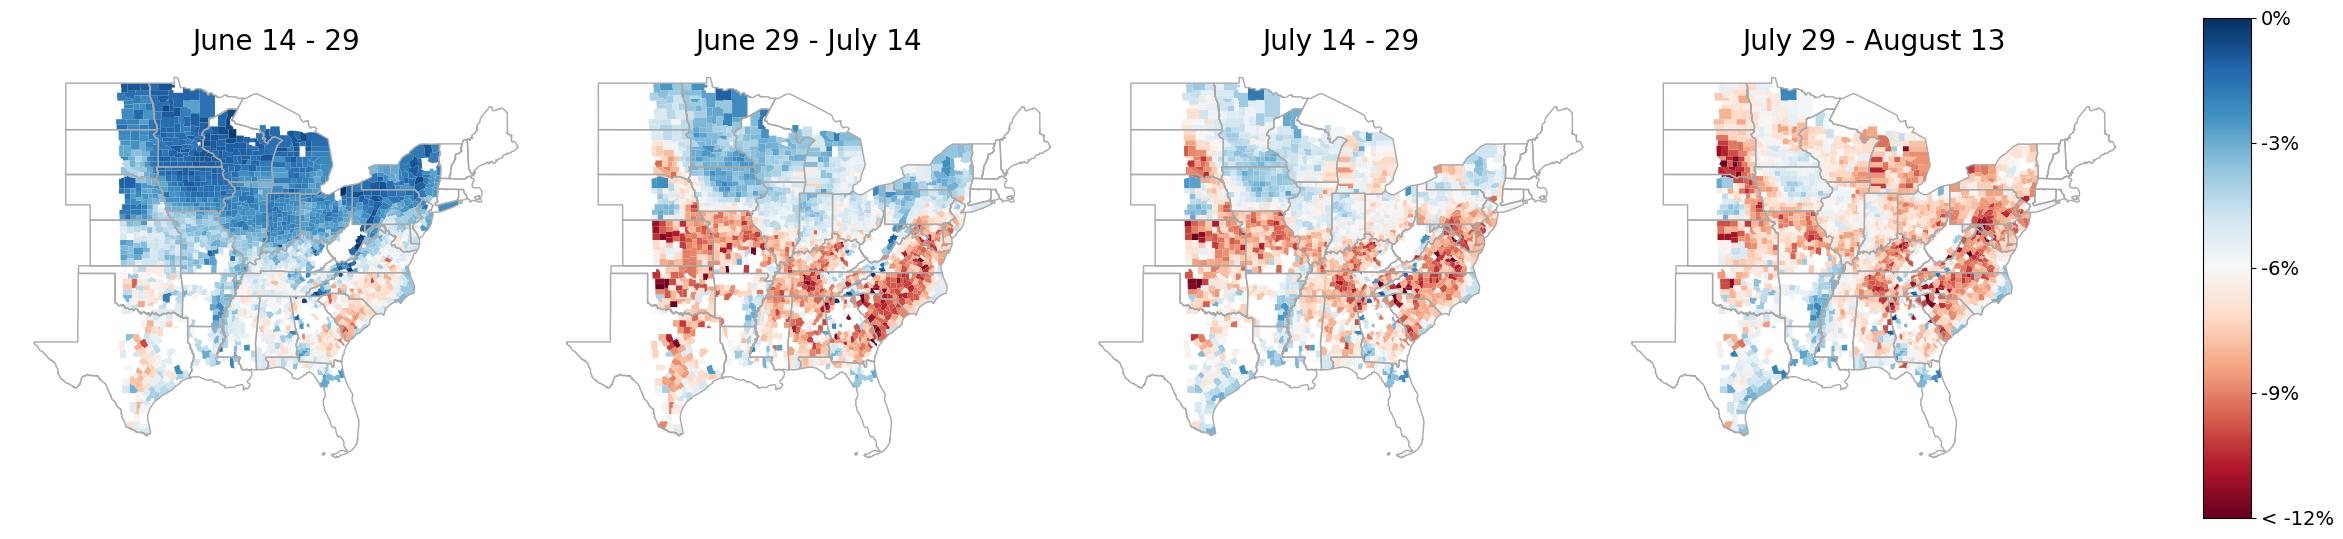

In [ ]:
#@title Map heat sensitivity by county
sens_df['fips'] = sens_df['fips'].apply(lambda x: str(x).zfill(5))

periods = [7, 8, 9, 10, 11]

fig, ax = plt.subplots(
    1, 4, figsize=(24, 10), gridspec_kw={'wspace': 0, 'hspace': 0})
vmin = sens_df.loc[(sens_df['tMax'] == 35) & (sens_df['period'].isin(periods)), 'delta'].quantile(0.01)
vmax = 0 #sens_df.loc[(sens_df['tMax'] == 35) & (sens_df['period'].isin(periods)), 'delta'].quantile(0.99)

ax[0].set_title('June 14 - 29', fontsize=20)
ax[1].set_title('June 29 - July 14', fontsize=20)
ax[2].set_title('July 14 - 29', fontsize=20)
ax[3].set_title('July 29 - August 13', fontsize=20)

cmap = 'RdBu'
vmin, vmax = -0.12, 0
for i in range(4):
    plot_df = counties_plot.merge(
        sens_df[(sens_df['period'] == periods[i]) & (sens_df['tMax'] == 35)])
    plot_df.plot(column='delta', ax=ax[i], cmap=cmap, vmin=vmin, vmax=0, legend=False)

    states_plot.plot(ax=ax[i], linewidth=1, edgecolor='darkgray', facecolor='none')
    ax[i].set_axis_off()

cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])  # Adjust as needed
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_ticks([0, -0.03, -0.06, -0.09, -0.12])
cbar.set_ticklabels(['0%', '-3%', '-6%', '-9%', '< -12%'], fontsize=14)

fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust to make space for the color bar
# fig.savefig(
#     f'{FIG_PATH}/geographic_heat_sensitivity_4.png', dpi=300, bbox_inches='tight', pad_inches=0.2)

fig.show()